# Airbnb Data - EDA and data visualization 
## with pandas, numpy, matplotlib and seaborn

This notebook performs basic EDA and data visualization (data viz) on a cleansed open-source Airbnb dataset from Kaggle. The goal is to extract meaningful insights for customers and air bnb users.

The dataset includes listing-level information such as location, price, availability, and review activity.

🔗 Source of raw, uncleansed data: [Airbnb Open Data on Kaggle](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata)

Note: This is a personal data science project for educational purposes. To reproduce the results, please download the dataset directly from Kaggle and run it through my data cleansing notebook which you can find here: [Click here to view GitHub cleansing repo](https://github.com/mg-ds-portfolio/prj_open_airbnb_data_cleanse.git)

In [64]:
# Import packages.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [65]:
# Configure chart displays and float display.

# Allow in-line plotting.
%matplotlib inline

# Set plot style.
plt.style.use("seaborn-v0_8-whitegrid")

In [66]:
# import raw data and take a copy to work on.
df_raw = pd.read_csv("/home/mark/data_viz_practice/data/airbnb_open_data_cleaned.csv")
df = df_raw.copy()

In [67]:
# Inspect data.
df.head()

,id,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
0,1001254,brooklyn,kensington,40.64749,-73.97237,False,strict,private room,2020.0,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0
1,1002102,manhattan,midtown,40.75362,-73.98377,False,moderate,entire home/apt,2007.0,142.0,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0
2,1002403,manhattan,harlem,40.80902,-73.94190,True,flexible,private room,2005.0,620.0,124.0,3.0,0.0,NaN,0.00,5.0,1.0,352.0
3,1002755,brooklyn,clinton hill,40.68514,-73.95976,True,moderate,entire home/apt,2005.0,368.0,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0
4,1003689,manhattan,east harlem,40.79851,-73.94399,False,moderate,entire home/apt,2009.0,204.0,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0


In [68]:
# Check data types and number of unique values.
data_types = df.dtypes
count_nas = df.isna().sum()
count_unique = df.nunique()

pd.concat([data_types, count_nas, count_unique], axis = 1).rename(columns={0: "data_type", 1: "na_count", 2: "num_unique_values"})

,data_type,na_count,num_unique_values
id,int64,0,99812
neighbourhood_group,object,0,5
neighbourhood,object,0,224
lat,float64,0,21846
long,float64,0,17643
instant_bookable,bool,0,2
cancellation_policy,object,0,3
room_type,object,0,4
construction_year,float64,0,20
price,float64,0,1151


Observations:
- The only column with NAs is last_review. All others have been cleansed.
- Data types broadly align with content (int/float for numbers, object for strings)

Actions:
- Convert data types

In [69]:
# Convert columns to correct data type.

category_type_cols = ["neighbourhood_group", "instant_bookable", "construction_year", "cancellation_policy", "room_type"]
numeric_type_cols = ["id", "lat", "long", "price", "service_fee", "minimum_nights", "number_of_reviews", "reviews_per_month", "review_rate_number", "calculated_host_listings_count", "availability_365"]
string_type_cols = ["neighbourhood"]
datetime_type_cols = ["last_review"]

for col in category_type_cols:
    df[col] = df[col].astype("category")

for col in numeric_type_cols:
    df[col] = pd.to_numeric(df[col])

for col in string_type_cols:
    df[col] = df[col].astype("string")

for col in datetime_type_cols:
    df[col] = pd.to_datetime(df[col])

print("Conversion check:")
print("----------")
print(f"Category columns: {len(category_type_cols)}")
print(f"Numeric columns: {len(numeric_type_cols)}")
print(f"String columns: {len(string_type_cols)}")
print(f"Datetime columns: {len(datetime_type_cols)}")
print("----------")
print(f"Total # cols converted: {len(category_type_cols) + len(numeric_type_cols) + len(string_type_cols) + len(datetime_type_cols)}")

print(f"df width: {len(df.columns)}")

print("\n")

print(df.dtypes)

Conversion check:
----------
Category columns: 5
Numeric columns: 11
String columns: 1
Datetime columns: 1
----------
Total # cols converted: 18
df width: 18


id                                         int64
neighbourhood_group                     category
neighbourhood                     string[python]
lat                                      float64
long                                     float64
instant_bookable                        category
cancellation_policy                     category
room_type                               category
construction_year                       category
price                                    float64
service_fee                              float64
minimum_nights                           float64
number_of_reviews                        float64
last_review                       datetime64[ns]
reviews_per_month                        float64
review_rate_number                       float64
calculated_host_listings_count           float64
availab

Notes on conversion:
- review_rate_number left as float so we can perform numerical calculations on data

What useful information can we extract from this information? Let's look at it from 2 different perspectives - that of a customer, and that of an airbnb owner.

Customer POV questions:
- Where will I find the best deal (highest rating for the lowest price)?
    - Where are the properties located? In which neighbourhood will I have the most options?
    - How can I narrow my search? In general, where are the best rated properties? 
    - Are higher rated properties generally more expensive?

Owner questions:
- How can I make more money from my listing?
    - What features do more expensive listings have that I could replicate to justify charging more?
    - How can I increase the number of bookings?
        - If we assume number of reviews is indicative of number of bookings, what features do highly reviewed listings have?
    - Can I charge higher service fees?

Other questions:
- Do highly rated properties survive longer?
    
    

To create graphs in Matplotlib or Seaborn, follow the same 5 steps:
1. Prepare the data
2. Create the figure and axes
3. Create the plot
4. Format plot elements
5. Show the plot

In [70]:
# How many properties do we have in each neighbourhood_group?

# Step 1. Prepare the data

properties_per_ngroup = df["neighbourhood_group"].value_counts()
properties_per_ngroup

neighbourhood_group
manhattan        42588
brooklyn         40737
queens           12925
bronx             2632
staten island      930
Name: count, dtype: int64

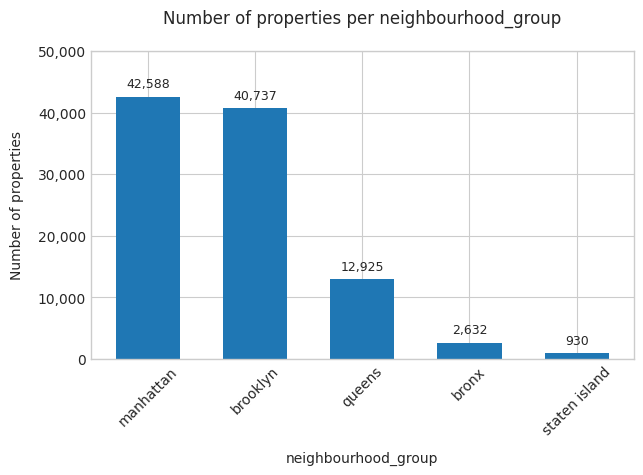

In [71]:
# Step 2. Create the figure and axes
fig, ax = plt.subplots(figsize = (7,4))

# Step 3. Create the plot
ax.bar(properties_per_ngroup.index, properties_per_ngroup.values, width = 0.6)

# Step 4. Format plot elements
ax.set_title("Number of properties per neighbourhood_group", pad = 20)
ax.set_xlabel("neighbourhood_group", labelpad = 10)
ax.set_ylabel("Number of properties", labelpad = 10)
ax.set_ylim(0, 50000)
ax.tick_params(axis = "x", rotation = 45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

for i, v in enumerate(properties_per_ngroup.values):
    ax.text(i, v + 1000, f"{v:,}", ha='center', va='bottom', fontsize=9)

# Step 5. Show plot
plt.show()

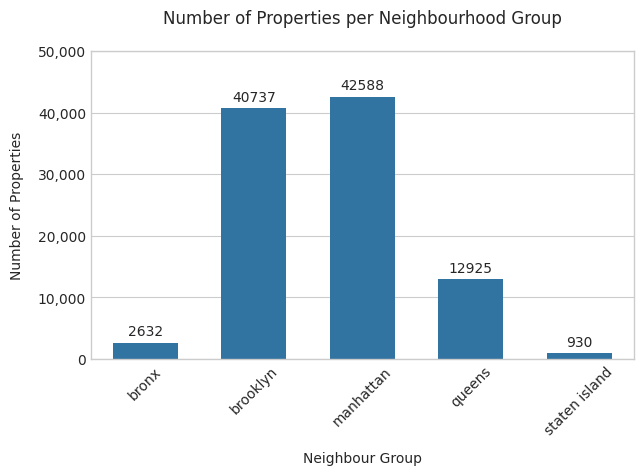

In [ ]:
# Let's recreate the same chart using Seaborn

# Step 1. Prepare the data
# Seaborn has a built in bar chart for counts, the countplot, so no need to prep the data.

#Step 2. Create figure and axes
fig, ax = plt.subplots(figsize = (7,4))

# Step 3. Create plot. 
sns.countplot(
    ax = ax,
    data = df, 
    x = "neighbourhood_group",
    width = 0.6)

# Step 4. Formatting
ax.set_title("Number of Properties per Neighbourhood Group", pad = 20)
ax.set_xlabel("Neighbour Group", labelpad = 10)
ax.set_ylabel("Number of Properties", labelpad = 10)
ax.set_ylim(0, 50000)
ax.tick_params(axis = "x", rotation = 45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

# Step 5. Show plot
plt.show()


Observations:
- As expected, there are significantly more properties for rent in manhattan and brooklyn.

This doesn't add much value, but let's plot the properties on a map. 

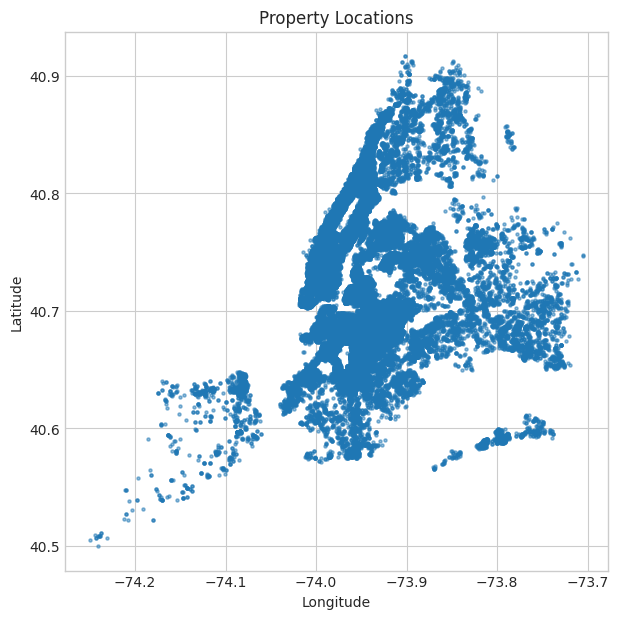

In [ ]:
# Step 1. Prepare the data.
# There's no need to prep data. We can map property location using lat and long.

# Step 2. Create fig and axes
fig, ax = plt.subplots(figsize = (7,7))

# Step 3. Create the plot
ax.scatter(
    x = df["long"], 
    y = df["lat"], 
    s = 5, 
    alpha = 0.5)

# Step 4. Format
ax.set_title("Property Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# Step 5. Show plot
plt.show()

This isn't very helpful on it's own. It essentially recreates a map of New York.

It might be interesting to see on this pseudo-map how other facets of the data vary. Let's create the same map in Seaborn but use hue to represent different property features.

Note: You can use size or style to represent other data fields, but with so many data points (~100k) it becomes difficult to spot differences in either size or marker style.

Since we're basically creating the same map multiple times with small tweaks, we use loops to generate multiple subplots at once.

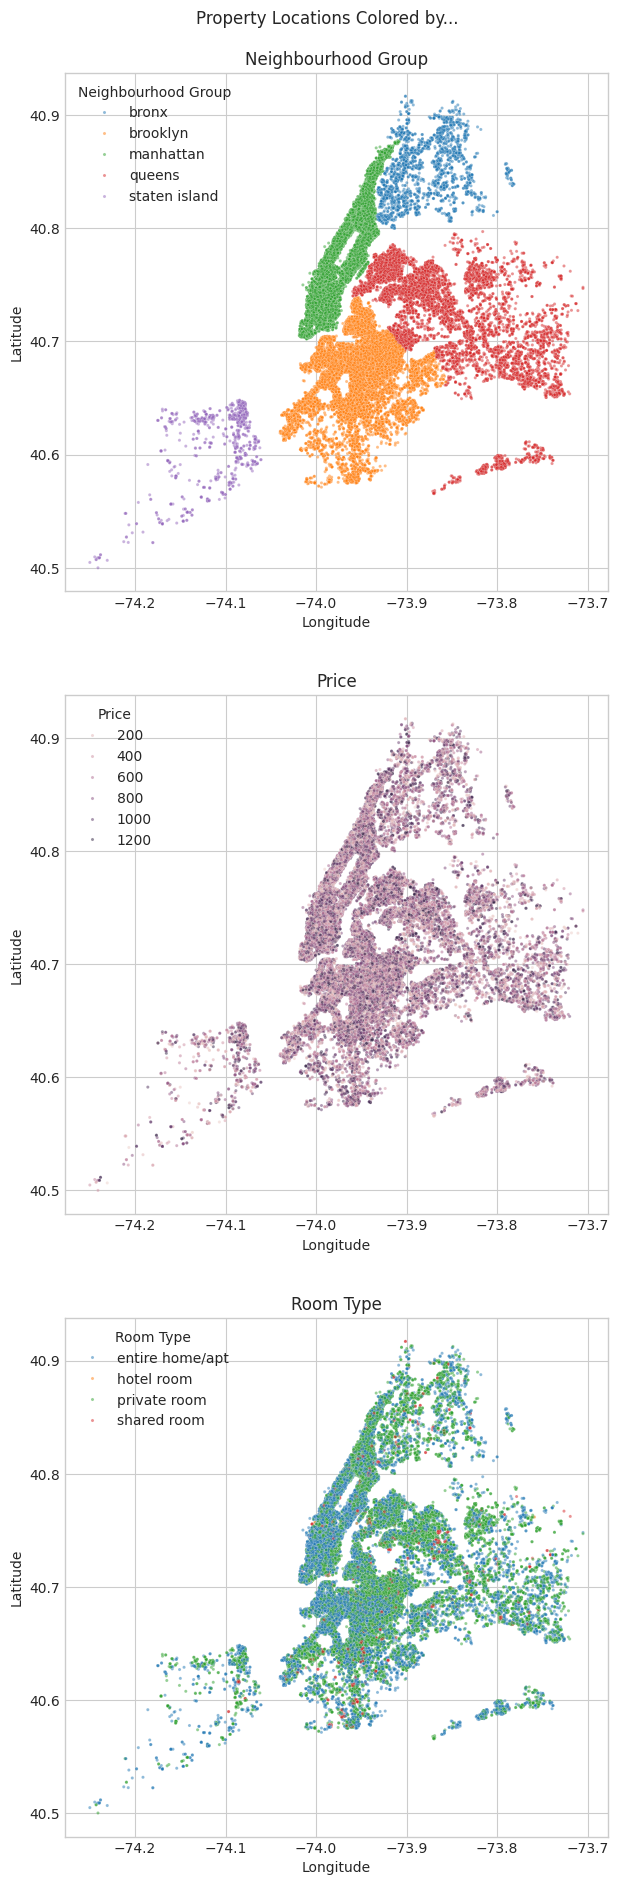

In [ ]:
# Step 1. Prepare the data. Set which columns hue will represent.
scatter_subplot_hue_data = ["neighbourhood_group", "price", "room_type"]

# Step 2. Create fig and 1x3 grid of axes
fig, axs = plt.subplots(len(scatter_subplot_hue_data),1, figsize = (7,21))
fig.subplots_adjust(top=0.95)

# Combine steps 3 and 4 - we're looping over each subplot. It's more efficient to create and format each plot in one go.
# Loop over all axes
for i, ax in enumerate(axs.flat):
    # Create subplots
    sns.scatterplot(
        ax = ax,
        data = df,
        x = "long", 
        y = "lat", 
        s = 5, 
        alpha = 0.5, 
        hue = scatter_subplot_hue_data[i]
    )
    
    # Format subplots
    ax.grid(True)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{scatter_subplot_hue_data[i].replace("_", " ").title()}")
    
    # Format legends
    legend = ax.legend()
    legend.set_title(f"{scatter_subplot_hue_data[i].replace("_", " ").title()}")
    legend.set_loc("upper left")

# Set title for grid of subplots
fig.suptitle("Property Locations Colored by...")

# Step 5. Show plot
plt.show()

Observations:
- With so many data points, we're not learning much from the scatter plots.
- The prices seem fairly evenly distributed across the neighbourhood groups. I was expecting more of a concentration of higher prices in Manhattan and Brooklyn but that doesn't seem to be a significant visual trend.

==== POSSILE IMPROVEMENTS TO THESE PLOTS ====
If we were publishing these plots in a report or wanted to improve the code, there are some improvements we could make, that weren't essential for this quick analysis.
- Make the legend markers larger. 
- Make the plots overlay a map of New York.
- Dynamically create the size of the figure based on the number of "hue" variables being inspected.

=============================================

Let's see which neighbourhood has the highest rated properties:

In [ ]:
# Step 1. Prep the data
avg_rating_by_nhood_grp = df.groupby("neighbourhood_group")["review_rate_number"].mean().sort_values(ascending = False)
avg_rating_by_nhood_grp

/tmp/ipykernel_125656/522761757.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating_by_nhood_grp = df.groupby("neighbourhood_group")["review_rate_number"].mean().sort_values(ascending = False)


neighbourhood_group
staten island    3.401075
bronx            3.329787
queens           3.327118
manhattan        3.278647
brooklyn         3.259518
Name: review_rate_number, dtype: float64

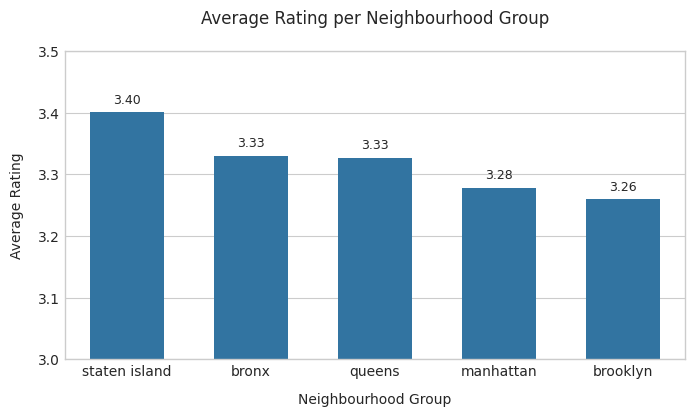

In [ ]:
# Step 2. Create fig and ax
fig, ax = plt.subplots(figsize = (8, 4))

# Step 3. Create plot
sns.barplot(x = avg_rating_by_nhood_grp.index, y = avg_rating_by_nhood_grp.values, ax = ax, order = avg_rating_by_nhood_grp.index, width = 0.6)

# Step 4. Format
ax.set_title("Average Rating per Neighbourhood Group", pad = 20)
ax.set_xlabel("Neighbourhood Group", labelpad = 10)
ax.set_ylabel("Average Rating", labelpad = 10)
ax.set_ylim(3,3.5)

for i, v in enumerate(avg_rating_by_nhood_grp.values):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

# Step 5. Show plot
plt.show()

Observation:
- The means are quite similar. We don't learn a lot about which neighbourhood group might have overall better properties.

Action:
- Create plots to see distribution of ratings per neighbourhood group.

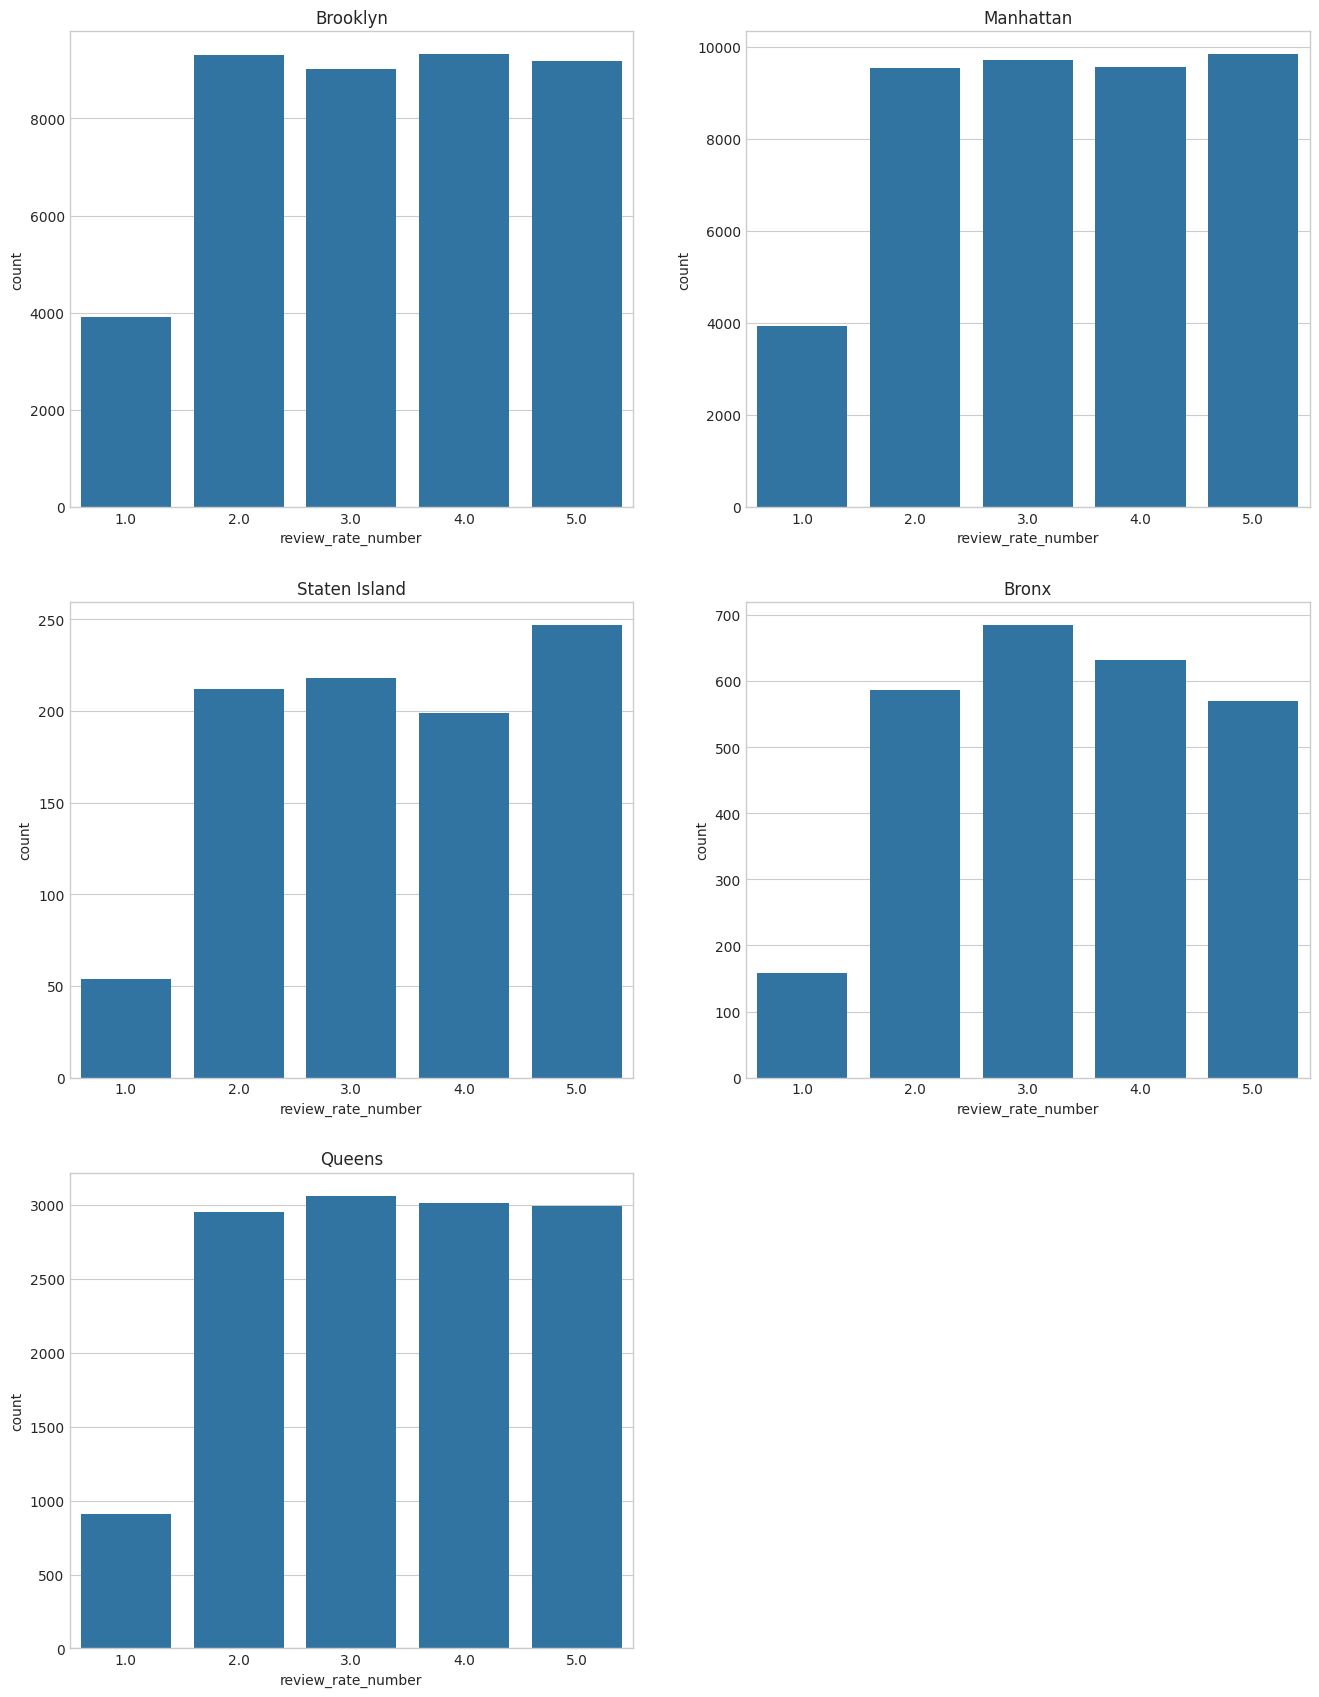

In [106]:
# Step 1. Prepare data
nhood_groups = df["neighbourhood_group"].unique()

# Step 2. Create fig and axs
fig, axs = plt.subplots(3, 2, figsize = (16,21))

# Step 3 and 4. Create and format
for nhood_group, ax in zip(nhood_groups, axs.flat):
    # Create subplots
    sns.countplot(
        ax = ax,
        data = df[df["neighbourhood_group"] == nhood_group],
        x = "review_rate_number"
    )
    ax.set_title(nhood_group.title())

# Step 5. Show plot. We'll also tidy up unused plots
for ax in axs.flat[len(nhood_groups):]:
    ax.axis("off")
plt.show()


Observation:
- This is unexpected. These plots show that there is a roughly even distribution of properties with ratings between 2 and 5. I was expecting there to be a peak around 3.